In [1]:
# Si tu estructura es cython_dbscan/dbscan_core.so, asegúrate de incluir el path
import os, sys
project_root = os.path.abspath("..")       # ajusta según dónde esté el notebook
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importa tu módulo compilado
from cython_dbscan.dbscan_core import dbscan

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from src.Segmenter_v2.Segmenter import build_segment_matrix_index,save_segment_index_to_json
import matplotlib.cm as cm

df = pd.read_parquet('../Data/sample_jan_2021.parquet')
df.head()

,mmsi,longitude,latitude,imo,vessel_name,callsign,vessel_type,vessel_type_cargo,length,width,destination,draught,sog,cog,heading,nav_status,dt_pos_utc,vessel_type_main,H3_int_index_15,res_8
1172258,257600000.0,10.810000,55.746667,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.0,7.0,154.0,Under Way Using Engine,2021-01-01 00:00:50,None,644562452806690699,881f222c31fffff
1172259,257600000.0,10.810388,55.748605,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.4,6.6,8.0,Under Way Using Engine,2021-01-01 00:01:00,None,644562452806187528,881f222c31fffff
1172260,259372000.0,24.117868,57.007650,9118496,CHRISTINA,LIJG3,Tanker,No Additional Information,124.0,20.0,LV RIX,5.6,0.0,316.9,47.0,Moored,2021-01-01 00:01:05,Oil And Chemical Tanker,644566704828286749,881f600c35fffff
1172261,257550000.0,0.562263,54.127452,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.7,136.3,138.0,Under Way Using Engine,2021-01-01 00:01:14,None,644459251375659225,88194464e7fffff
1172262,257550000.0,0.561667,54.126667,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.0,136.0,0.0,Under Way Using Engine,2021-01-01 00:01:17,None,644459251374645290,88194464e7fffff


In [4]:
segment_index = build_segment_matrix_index(df)

In [5]:
save_segment_index_to_json(segment_index)

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm

def extract_all_coords_from_segments(segment_index):
    coords_all = []
    for segment_data in segment_index.values():
        for neighbor in segment_data["neighbors"]:
            for point in neighbor["res_15_points"]:
                coords_all.append((point["lat"], point["lon"]))
    return np.array(coords_all, dtype=np.float64)

def run_dbscan_sklearn(coords, eps=0.1, min_samples=3):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = db.fit_predict(coords)
    return labels

def plot_clusters(coords, labels):
    plt.figure(figsize=(12, 8))

    # Excluir el ruido (-1)
    unique_labels = set(labels)
    unique_labels.discard(-1)  # ⬅️ Esta línea es clave

    cmap = plt.colormaps.get_cmap("tab10")

    for i, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(
            coords[mask, 1],
            coords[mask, 0],
            s=10,
            label=f"Cluster {label}",
            color=cmap(i % 10)
        )

    plt.title("Clusters con DBSCAN (sklearn)")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

DBSCAN sklearn ejecutado en 2.06 segundos


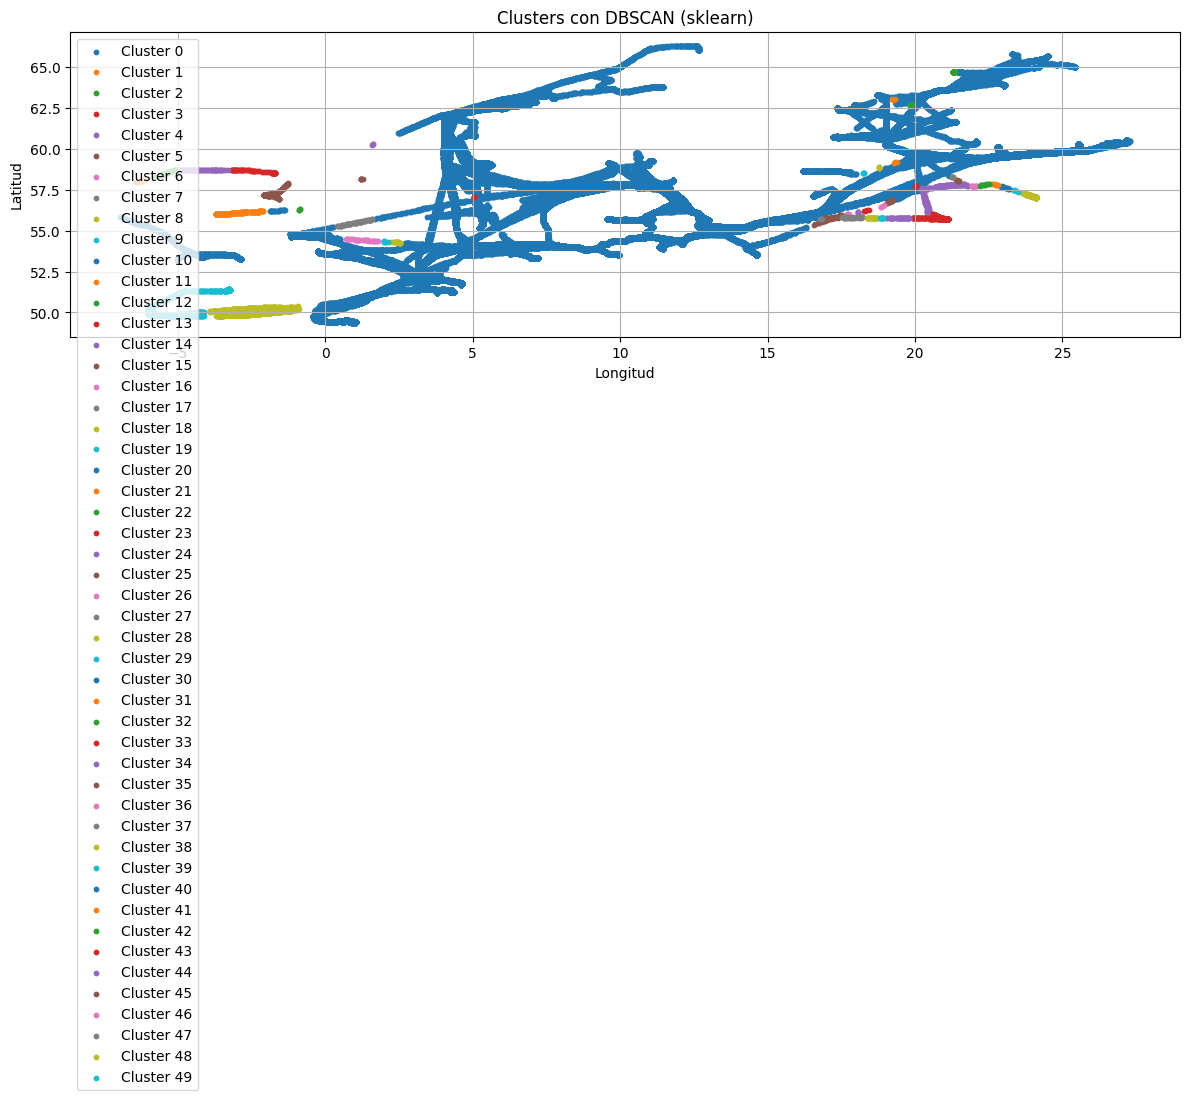

In [16]:
import time

with open("segment_index.json") as f:
    segment_index = json.load(f)

coords = extract_all_coords_from_segments(segment_index)

start = time.time()
labels = run_dbscan_sklearn(coords, eps=0.1, min_samples=3)
end = time.time()

print(f"DBSCAN sklearn ejecutado en {end - start:.2f} segundos")
plot_clusters(coords, labels)

In [17]:
cluster_0 = coords[labels == 0]